## GLORYS Marine Heatwaves and Cold Spells

What kind of bottom-water dynamics can we see using glorys bottom temperatures from the last year?



In [1]:
import xarray as xr
import xmhw
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
#import oisstools as ot
import glob
import dask


# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/"
#daily_path = f"{glorys_path}NE_Shelf_Tempsal/" # all depths

# Path to GLORYS Surface + Bottom Dataset(s)
surfbot_path = f"{glorys_path}NE_Shelf_Surfbot_Daily/" # surface and bottom only
surfbot_monthly_path = f"{glorys_path}NE_Shelf_TempSal_Monthly/" # tempsal+surfbot+clim+anoms

# Set Start and End Year to Load
start_year = 1993
end_year = 2024


In [2]:
# Paths to Historical datasets that were regridded with cdo tools
surfbot_files = glob.glob(f'{surfbot_path}CMEMS_Northeast_TempSal*.nc')
monthly_files = glob.glob(f'{surfbot_monthly_path}CMEMS_Northeast_TempSal*.nc')
#surfbot_files[0]

# Paths to scenario datasets that were regridded with cdo tools
surfbot_ds = xr.open_mfdataset(surfbot_files, combine = "by_coords")
#surfbot_monthly = xr.open_dataset(f"{surfbot_monthly_path}Northwest_Atlantic_Surface_Bottom_93to2022_anoms.nc")
surfbot_ds

<xarray.Dataset>
Dimensions:       (time: 11681, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2024-12-24
  * latitude      (latitude) float32 35.25 35.33 35.42 35.5 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 -75.67 -75.58 -75.5 ... -57.0 -56.92
Data variables:
    bottom_temp   (time, latitude, longitude) float64 dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_sal   (time, latitude, longitude) float64 dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_sal    (time, latitude, longitude) float64 dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

### Setting Extreme Event Thresholds

The `xmhw` library has automated the process of producing a daily climatology and apply mhw thresholds. We can use this library to get our mhw thresholds for the data.

In [3]:
# from xmhw.xmhw import threshold, detect
# bt = surfbot_ds["bottom_temp"]
# bt_clim = threshold(
#     bt, 
#     climatologyPeriod = [1993, 2022], 
#     pctile = 90, 
#     coldSpells = False)
# bt_clim

# bt_mhw = detect(bt, bt_clim['thresh'], bt_clim['seas'])
# bt_mhw

## Processing Thresholds Manually

In [4]:
# Day of year is just 1...n no matter if leap  year or no
surfbot_ds = surfbot_ds.assign_coords({"doy" : surfbot_ds.time.dt.dayofyear}) 

In [14]:
def calc_ref_thresholds(x, start_year, end_year, thresh_var = "sst", mhw_pct = 0.9, clim_idx = "doy"):
    """
    x: xr.dataset with sst data indexed by time and with some daily climatology index to use like day of year (doy)
    start_year: starting year to use for reference period for thresholds and averages
    end_year: ending year to use for reference period for thresholds and averages
    mhw_pct: Percentile to use to set MHW threshold using quantile
    clim_idx: string indicating the index to group over for daily/monthly climatological references
    """
    
    # Pull the reference period years - Limit to the 30 years of interest
    ref_period = x.sel(time = slice(f"{start_year}-01-01", f"{end_year}-12-31")).chunk({"time": -1})[thresh_var]

    # Group on the modified ordinal day then get the means for climatological average
    x_clim = ref_period.groupby(clim_idx).mean('time', keep_attrs = True).to_dataset().rename_vars({thresh_var : f"{thresh_var}_clim"})

    # Set MHW threshold
    
    # Get Quantile thresholds by modified ordinal day
    hw_threshold = ref_period.groupby(clim_idx).quantile(mhw_pct, dim='time', keep_attrs=True, skipna=True).to_dataset().rename_vars({thresh_var : "hw_thresh"})

    # # Cold Spells
    mcs_pct = 1 - mhw_pct
    cs_threshold = ref_period.groupby(clim_idx).quantile(mcs_pct, dim='time', keep_attrs=True, skipna=True).to_dataset().rename_vars({thresh_var : "cs_thresh"})

    # Merge them to Get a complete building block for MHW
    ref_thresholds = xr.merge([x_clim, hw_threshold.drop("quantile"), cs_threshold.drop("quantile")])

    # Return the xarray.dataset
    return ref_thresholds

In [18]:
# Limits to climatology years:
clim_start = 1993
clim_end = 2022


# Run Calculations to create the thresholds
ref_thresholds = calc_ref_thresholds(
    x = surfbot_ds, 
    start_year = clim_start, 
    end_year = clim_end, 
    thresh_var = "bottom_temp",
    mhw_pct = 0.9, 
    clim_idx = "doy")

ref_thresholds

<xarray.Dataset>
Dimensions:           (latitude: 132, longitude: 226, doy: 366)
Coordinates:
  * latitude          (latitude) float32 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude         (longitude) float32 -75.67 -75.58 -75.5 ... -57.0 -56.92
  * doy               (doy) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Data variables:
    bottom_temp_clim  (doy, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    hw_thresh         (doy, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    cs_thresh         (doy, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>

In [19]:
# Apply a rolling average to climat reference thresholds
def smooth_clim(x, clim_idx = "doy", window_len = 6, center = True, min_periods = 1):

    # Length of the array to append to
    array_len = x[clim_idx].shape[0]

    # Days to place in the front
    head_buffer = x.sel(doy = slice(array_len - window_len, array_len))
    head_buffer = head_buffer.assign_coords({"doy" : head_buffer.coords[clim_idx] - array_len})

    # # These days will append to the end:
    tail_buffer = x.sel(doy = slice(0, window_len))
    tail_buffer = tail_buffer.assign_coords({"doy" : tail_buffer.coords[clim_idx] + array_len})

    # Combine & Check them
    roll_rdy = xr.concat([head_buffer, x,  tail_buffer], dim = "doy")

    # Perform rolling average
    x_rolled = roll_rdy.rolling(doy = window_len, center = center, min_periods = min_periods).mean()

    # take off the header
    x_rolled = x_rolled.sel(doy = slice(1, 366))

    return x_rolled

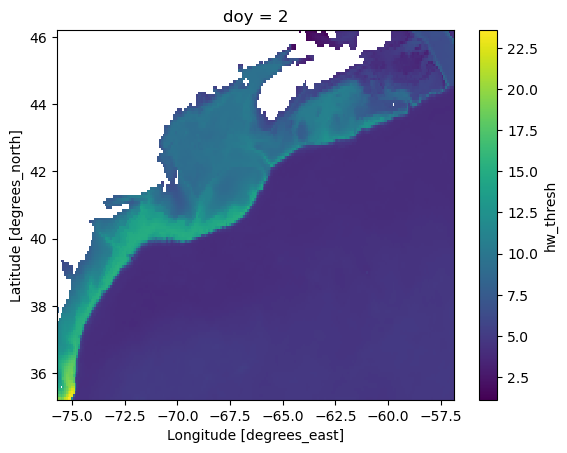

In [23]:
# plot to show results
ref_rolled = smooth_clim(x = ref_thresholds, clim_idx = "doy", window_len = 6)
ref_rolled.bottom_temp_clim.mean(("longitude", "latitude")).plot()

# # # What do the thresholds look like on a map?
ref_rolled.isel(doy = 1).hw_thresh.plot()

In [26]:
# Define a function to: 
# 1. match trend residuals to the climatological mean & thresholds for each day
# 2. Flag when those new values exceed thresholds for extreme events

def detect_extreme_events(obs_ds, threshold_ds, test_var = "sst", clim_idx = "doy", thresh_high = "hw_thresh", thresh_low = "cs_thresh"):
    """
    obs_ds: xr.dataset containing de-trended temperatures or some other variable
    threshold_ds: xr.dataset containing the climatological mean and extreme event thresholds for some reference period
    """

    # pull the climatology slice that matches the day of the year
    threshold_match = threshold_ds.sel(doy = obs_ds[clim_idx])

    # # Compare if they are over the threshold or no, event flagging
    obs_ds["is_hw"] = getattr(obs_ds, test_var) > getattr(threshold_match, thresh_high)
    obs_ds["is_cs"] = getattr(obs_ds, test_var) < getattr(threshold_match, thresh_low)

    return obs_ds.drop("doy")

In [27]:
# Plot the detrended sst + climatological mean
events_ds = surfbot_ds.groupby("time").map(
    detect_extreme_events, 
    threshold_ds = ref_rolled, 
    test_var = "bottom_temp", 
    thresh_high = "hw_thresh", 
    thresh_low = "cs_thresh")
events_ds

<xarray.Dataset>
Dimensions:       (time: 11681, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2024-12-24
  * latitude      (latitude) float32 35.25 35.33 35.42 35.5 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 -75.67 -75.58 -75.5 ... -57.0 -56.92
Data variables:
    bottom_temp   (time, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    surface_sal   (time, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    bottom_sal    (time, latitude, longitude) float64 dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    is_hw         (time, latitude, longitude) bool dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    is_cs         (time, latitude, longitude) bool dask.array<chunksize=(1, 132, 226), meta=np.ndarray>

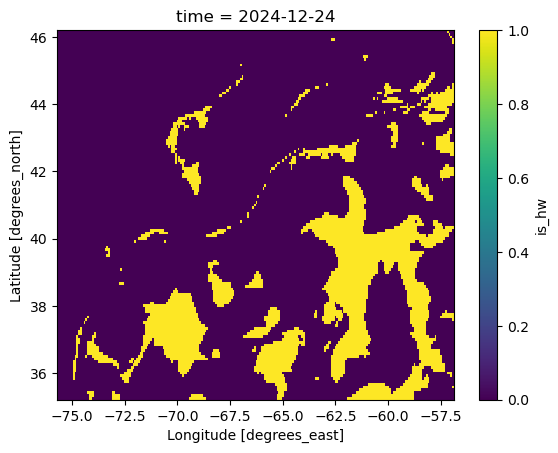

In [28]:
# Plot what a day of hw events looks like
events_ds.isel(time = -1).is_hw.plot()

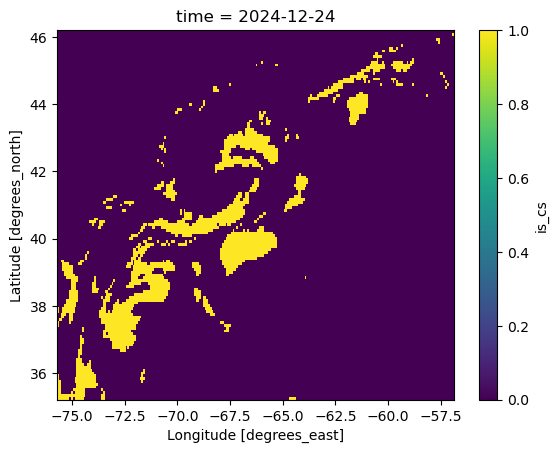

In [29]:
# Plot what a day of hw events looks like
events_ds.isel(time = -1).is_cs.plot()

In [ ]:
# Save Glorys Cold Spells? Na